# Dynamic Analysis in Zebrafish Neural Crest Development

This tutorial provides a step-by-step workflow for analyzing transcriptional dynamics in our newly sequenced zebrafish Smart-seq3 dataset, focused on neural crest cell development. Leveraging state-of-the-art tools such as `scvelo` and `cellrank`, this guide centers on the use of the `regvelo` package to model RNA velocity with gene regulatory priors.

We walk through the complete pipeline, from data preprocessing to model training and transcription factor perturbation analysis. The goal is to uncover key regulators and dynamic processes shaping neural crest development, providing a reproducible framework for applying `regvelo` to similar single-cell transcriptomics studies.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch

import cellrank as cr
import scvi

import mplscience
import matplotlib.pyplot as plt
import seaborn as sns

from velovi import preprocess_data

from regvelo import REGVELOVI
import regvelo as rgv

/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regve

In [2]:
scvi.settings.seed = 0

[rank: 0] Global seed set to 0


In [3]:
%matplotlib inline

In [4]:
plt.rcParams["svg.fonttype"] = "none"
scv.settings.set_figure_params("scvelo", dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Load data

In [5]:
adata = rgv.datasets.zebrafish_nc()
prior_net = rgv.datasets.zebrafish_grn()
TF_list = adata.var_names[adata.var["is_tf"]].tolist()

In [6]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
scv.pp.moments(adata)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


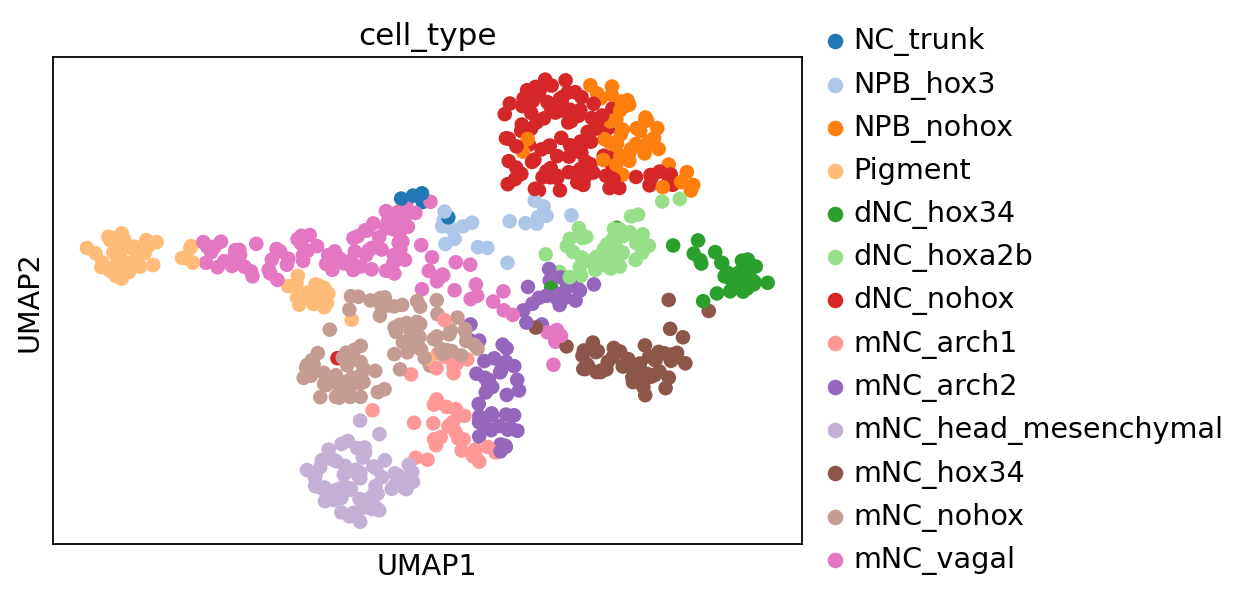

In [7]:
sc.pl.umap(adata, color='cell_type',palette=sc.pl.palettes.vega_20)

## Preprocessing

In [8]:
adata = preprocess_data(adata)
adata = rgv.pp.set_prior_grn(adata,prior_net)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [9]:
TF_list = set(TF_list).intersection(adata.var_names)
TF_list = list(TF_list)
print("final number of TFs: "+str(len(TF_list)))

final number of TFs: 81


In [10]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W))

In [11]:
sparsity = W.sum() / ((W.sum(1) != 0).sum() * W.shape[0])
print("network sparsity: "+str(np.array(sparsity)))

network sparsity: 0.052775327


## Training RegVelo model

In [12]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
reg_vae = REGVELOVI(adata, W=W.T, regulators=TF_list, soft_constraint=False)

In [13]:
reg_vae.train()

/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/en

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2406.869. Signaling Trainer to stop.


In [14]:
adata_target = reg_vae.add_regvelo_outputs_to_adata(adata=adata)

In [15]:
scv.tl.velocity_graph(adata_target)

computing velocity graph (using 1/112 cores)


  0%|          | 0/697 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Predict terminal states

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


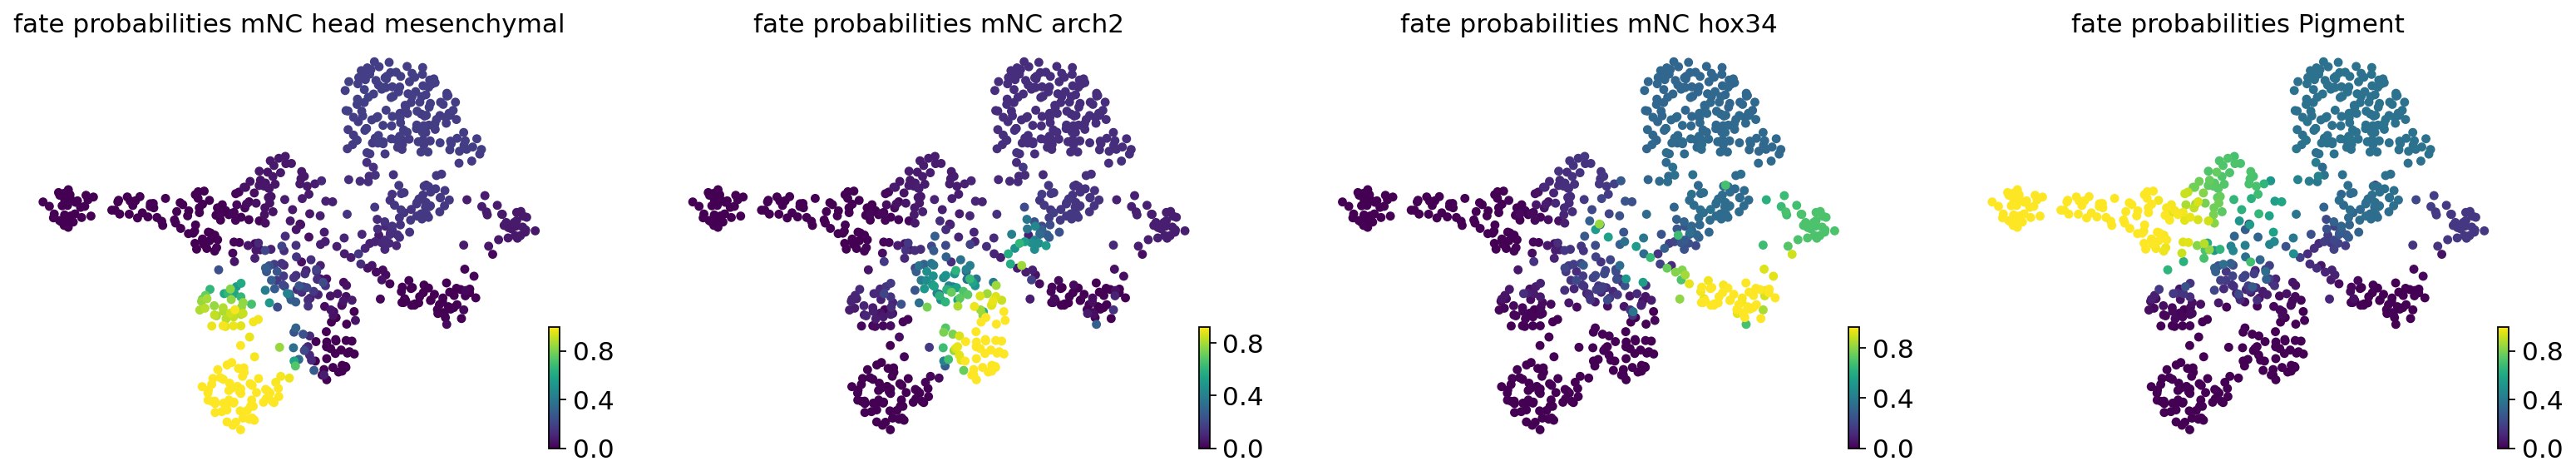

In [16]:
terminal_states = ["mNC_head_mesenchymal",
                   "mNC_arch2",
                   "mNC_hox34",
                   "Pigment",
                  ]
vk = cr.kernels.VelocityKernel(adata_target).compute_transition_matrix()
estimator = cr.estimators.GPCCA(vk)

## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=7, cluster_key="cell_type")
estimator.set_terminal_states(terminal_states)
estimator.compute_fate_probabilities()
estimator.plot_fate_probabilities(same_plot=False)

/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs

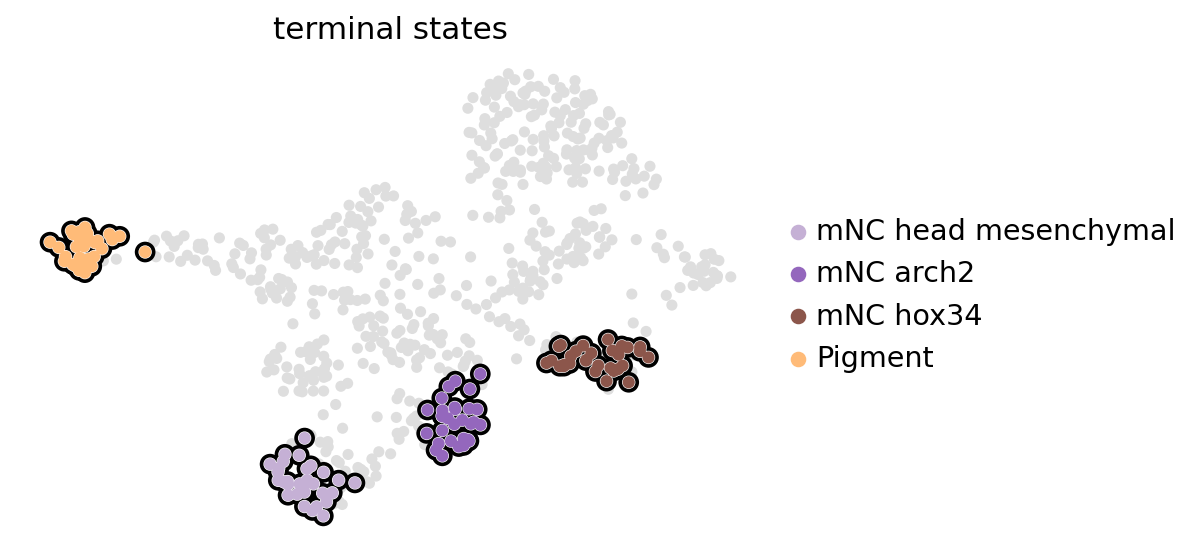

In [17]:
estimator.plot_macrostates(which="terminal", legend_loc="right", s=100)

## Save model

In [18]:
reg_vae.save("rgv_model")

## Perform perturbation screening

In the perturbation screening step, RegVelo enables users to generate a perturbed vector matrix, which is saved in `adata_target_perturb.layers["velocity"]`. Subsequently, a new CellRank kernel is constructed using the perturbed vector matrix, resulting in an estimated matrix of perturbed cell fate probabilities.

Terminal states for the perturbed dynamics can be defined in two ways: either by directly setting them with `estimator.set_terminal_states(terminal_states)` or by using the terminal state indices defined in the original dynamics by CellRank.

In [19]:
ct_indices = {}
for ct in terminal_states:
    indices = adata_target.obs["term_states_fwd"][adata_target.obs["term_states_fwd"] == ct].index.tolist()
    ct_indices[ct] = indices

In [20]:
fate_prob_perturb = []
cand_list = ["nr2f5","sox9b","twist1a","twist1b","sox10","mitfa","tfec","tfap2b"]
for TF in cand_list:
    model = 'rgv_model'
    adata_target_perturb,reg_vae_perturb =  rgv.tl.in_silico_block_simulation(model,adata,TF,cutoff = 0)
    ### predict the terminal state dfference
    n_states = 7
    vk = cr.kernels.VelocityKernel(adata_target_perturb).compute_transition_matrix()
    estimator = cr.estimators.GPCCA(vk)
    ## evaluate the fate prob on original space
    estimator.compute_macrostates(n_states=n_states,cluster_key="cell_type")
    
    
    estimator.set_terminal_states(ct_indices)
    estimator.compute_fate_probabilities()
    ## visualize coefficient
    cond1_df = pd.DataFrame(adata_target_perturb.obsm["lineages_fwd"], columns=adata_target_perturb.obsm["lineages_fwd"].names.tolist())
    cond1_df = cond1_df.loc[:,terminal_states]
    
    fate_prob_perturb.append(cond1_df)

INFO     File rgv_model/model.pt already downloaded                                                                


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File rgv_model/model.pt already downloaded                                                                


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


In [21]:
cond2_df = pd.DataFrame(adata_target.obsm["lineages_fwd"], columns=adata_target.obsm["lineages_fwd"].names.tolist())
df = []
for i in range(len(fate_prob_perturb)):
    data = rgv.tl.abundance_test(cond2_df, fate_prob_perturb[i])
    data = pd.DataFrame(
        {
            "Score": data.iloc[:, 0].tolist(),
            "p-value": data.iloc[:, 1].tolist(),
            "Terminal state": data.index.tolist(),
            "TF": [cand_list[i]] * (data.shape[0]),
        }
    )
    df.append(data)

df = pd.concat(df)

df["Score"] = (0.5 - df["Score"])*2

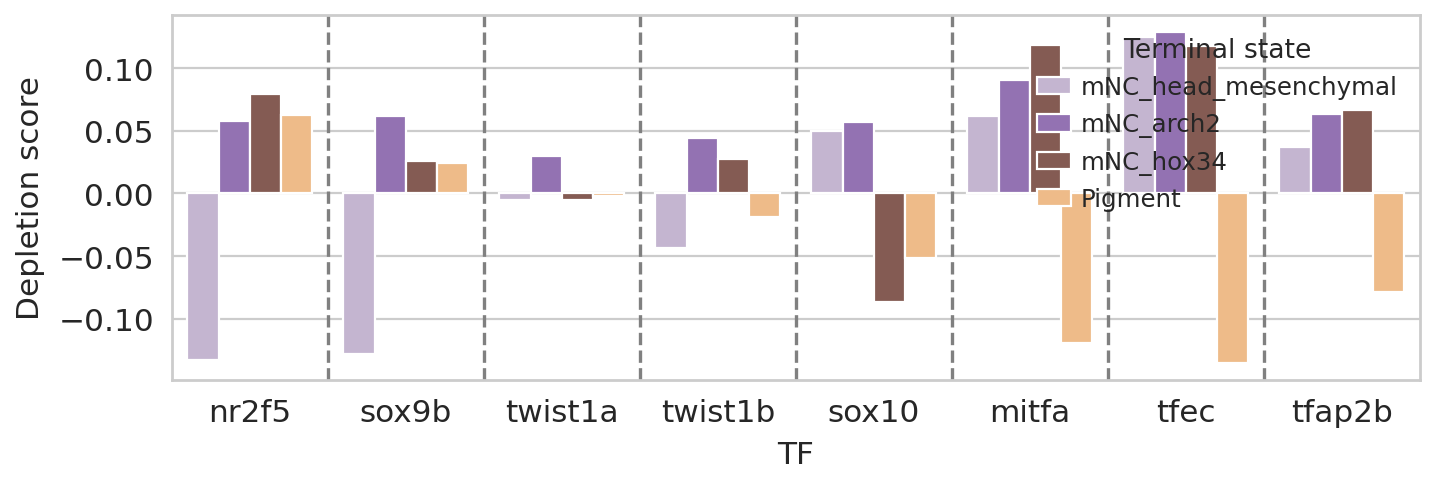

In [22]:
with mplscience.style_context():
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10,3))
    #sns.barplot(x='Terminal state', y='AUROC',data=data, hue = "Method",palette=pal,ax = ax)
    color_label = "cell_type"
    palette = dict(zip(adata.obs[color_label].cat.categories, adata.uns[f"{color_label}_colors"]))
    subset_palette = {name: color for name, color in palette.items() if name in cond2_df.columns.tolist()}

    sns.barplot(x='TF', y='Score', hue='Terminal state', data=df, ax=ax, palette=palette, dodge=True)

    # Add vertical lines to separate groups
    for i in range(len(df['TF'].unique()) - 1):
        plt.axvline(x=i + 0.5, color='gray', linestyle='--')

    # Label settings
    plt.ylabel('Depletion score', fontsize=14)
    plt.xlabel('TF', fontsize=14)
    plt.xticks(fontsize=14)  # Increase font size of x-axis tick labels
    plt.yticks(fontsize=14)  # Increase font size of y-axis tick labels
    plt.show()

## Screening different KO combination

After completing all the steps above, the user can set parameters such as `n_states` in `rgv.tl.TFscreening` to perform end-to-end computations. This function also provides the `n_repeats` argument, which can be set to `n_repeats = 5` to run the model five times and obtain aggregated perturbation results for more stable estimations. In default we merely run model for single time

In [23]:
KO_list = ["tfec","mitfa","fli1a_sox9b","nr2f5"]

perturb_likelihood, perturb_pval = rgv.tl.TFscreening(adata=adata,
                                                      prior_graph=W.T,
                                                      soft_constraint=False,
                                                      TF_list=TF,
                                                      cluster_label="cell_type",
                                                      terminal_states=terminal_states,
                                                      KO_list=KO_list,
                                                      n_states=8,
                                                      cutoff=0)

/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/en

training model...


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2410.081. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/regvelo_repo_develop/perturb_repeat_runs/rgv_model_0/model.p
         t already downloaded                                                                                      


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/regvelo_repo_develop/perturb_repeat_runs/rgv_model_0/model.p
         t already downloaded                                                                                      


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done tfec
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/regvelo_repo_develop/perturb_repeat_runs/rgv_model_0/model.p
         t already downloaded                                                                                      


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done mitfa
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/regvelo_repo_develop/perturb_repeat_runs/rgv_model_0/model.p
         t already downloaded                                                                                      


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done fli1a_sox9b
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/regvelo_repo_develop/perturb_repeat_runs/rgv_model_0/model.p
         t already downloaded                                                                                      


/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo-py310/l ...
  rank_zero_warn(


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

Done nr2f5


In [24]:
2*(0.5 - perturb_likelihood)

,mNC_head_mesenchymal,mNC_arch2,mNC_hox34,Pigment
fli1a_sox9b,-0.165631,-0.069976,0.082154,0.065867
mitfa,0.036844,0.076209,0.110951,-0.108543
nr2f5,-0.121622,0.064200,0.073249,0.043064
tfec,0.113738,0.114442,0.114088,-0.133483
